In [3]:
import json
import shelve
from tqdm import tqdm
import random
import csv

import matplotlib.pyplot as plt

from data.ag.action_genome import AG, AGViewer
from util.graph_utils import check_edge_exists

VERBS = [
    "awaken",
    "close",
    "cook", 
    "dress",
    "drink",
    "eat",
    "fix",
    "grasp", 
    "hold",
    #"laugh",
    "lie",
    "make",
    "open",
    "photograph",
    "play",
    "pour",
    "put",
    "run",
    "sit",
    #"smile",
    #"sneeze",
    "snuggle",
    "stand",
    "take",
    "talk",
    "throw",
    "tidy",
    "turn",
    "undress",
    "walk",
    "wash",
    "watch",
    "work"
]

root = '/data/Datasets/ag/'
subset_file = 'data/ag/subset_shelve'
ag = AG(root, no_img=True, split=None, subset_file=subset_file, verb_whitelist=VERBS)
#ag = AG(root, split=None, subset_file=None, verb_blacklist=['smile', 'laugh', 'sneeze']) #view the full dataset
#ag = AG(root, split='test', subset_file='data/ag/subset_shelve') #view the test split dataset
#ag = AG(root, split='train', subset_file='data/ag/subset_shelve') #view the test split dataset


In [5]:
print(ag.action_verb_obj_map)

{0: (8, 9), 1: (15, 9), 2: (20, 9), 3: (22, 9), 4: (23, 9), 5: (27, 9), 6: (1, 12), 7: (6, 12), 8: (11, 12), 9: (15, 31), 10: (17, 31), 11: (17, 31), 12: (23, 31), 13: (27, 31), 14: (29, 31), 15: (8, 23), 16: (13, 23), 17: (15, 23), 18: (20, 23), 19: (21, 23), 20: (8, 1), 21: (11, 1), 22: (15, 1), 23: (20, 1), 24: (22, 1), 25: (1, 4), 26: (8, 4), 27: (11, 4), 28: (15, 4), 29: (20, 4), 30: (22, 4), 31: (28, 4), 32: (8, 33), 33: (15, 33), 34: (20, 33), 35: (22, 33), 36: (23, 33), 37: (27, 33), 38: (1, 5), 39: (8, 5), 40: (11, 5), 41: (15, 5), 42: (20, 5), 43: (20, 5), 44: (22, 5), 45: (1, 18), 46: (8, 18), 47: (11, 18), 48: (15, 18), 49: (20, 18), 50: (28, 18), 51: (13, 18), 52: (8, 29), 53: (15, 29), 54: (3, 29), 55: (20, 29), 56: (25, 29), 57: (22, 29), 58: (17, 7), 59: (19, 7), 60: (8, 16), 61: (15, 16), 62: (20, 16), 63: (22, 16), 64: (5, 27), 65: (10, 27), 66: (8, 27), 67: (15, 27), 68: (20, 27), 69: (8, 3), 70: (15, 3), 71: (18, 3), 72: (20, 3), 73: (22, 3), 74: (23, 3), 75: (8, 25

In [6]:
#for a, (v, o) in sorted(ag.action_verb_obj_map.items(), key=lambda x: x[1][0]):
for a, (v, o) in ag.action_verb_obj_map.items():
    action = ag.action_classes[a]
    verb = ag.verb_classes[v]
    obj = None if o is None else ag.object_classes[o]
    print(action, f'({verb}, {obj})')

Holding some clothes (hold, clothes)
Putting clothes somewhere (put, clothes)
Taking some clothes from somewhere (take, clothes)
Throwing clothes somewhere (throw, clothes)
Tidying some clothes (tidy, clothes)
Washing some clothes (wash, clothes)
Closing a door (close, door)
Fixing a door (fix, door)
Opening a door (open, door)
Putting something on a table (put, table)
Sitting on a table (sit, table)
Sitting at a table (sit, table)
Tidying up a table (tidy, table)
Washing a table (wash, table)
Working at a table (work, table)
Holding a phone/camera (hold, phone/camera)
Playing with a phone/camera (play, phone/camera)
Putting a phone/camera somewhere (put, phone/camera)
Taking a phone/camera from somewhere (take, phone/camera)
Talking on a phone/camera (talk, phone/camera)
Holding a bag (hold, bag)
Opening a bag (open, bag)
Putting a bag somewhere (put, bag)
Taking a bag from somewhere (take, bag)
Throwing a bag somewhere (throw, bag)
Closing a book (close, book)
Holding a book (hold, b

In [4]:
%autoreload

with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break


UsageError: Line magic function `%autoreload` not found.


INDEX: 18653
[('person', 'looking_at', 'window'), ('window', 'in_front_of', 'person'), ('person', 'not_contacting', 'window'), ('person', 'looking_at', 'closet/cabinet'), ('closet/cabinet', 'in_front_of', 'person'), ('person', 'not_contacting', 'closet/cabinet')]


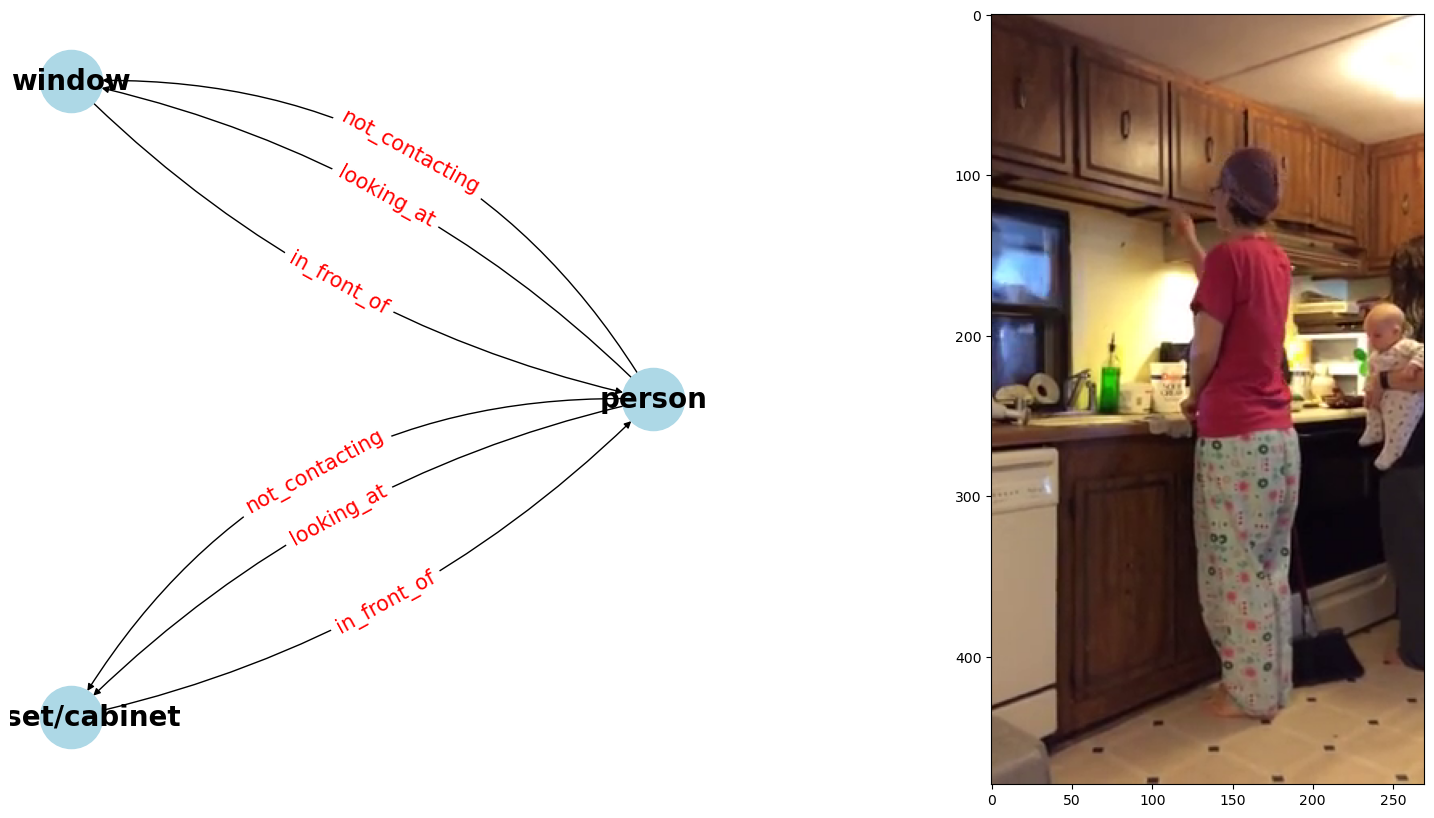

In [11]:
%autoreload
idx_list = list(range(len(ag)))
random.shuffle(idx_list)

correct_count = 0
incorrect_count = 0
with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict, human_test=True)
    for idx in idx_list:
        _, verb = agview.view(idx)
        if correct_count + incorrect_count > 0:
            accuracy = correct_count / (correct_count + incorrect_count)
        else:
            accuracy = 0
        answer = input(f"correct: {correct_count}, incorrect: {incorrect_count}, accuracy: {accuracy}")
        if answer == 'q':
            break
        if answer == verb:
            correct_count += 1
            print('CORRECT' + verb)
        else:
            incorrect_count += 1
            print('INCORRECT' + verb)


In [21]:
#Check for overlap between train, val, and test splits
with open('data/ag/split_train_val_test.json', 'r') as f:
    split_dict = json.load(f)
    train_ids = set(split_dict['train'])
    val_ids = set(split_dict['val'])
    test_ids = set(split_dict['test'])
    
    # Check for overlap
    train_val_overlap = train_ids.intersection(val_ids)
    train_test_overlap = train_ids.intersection(test_ids)
    val_test_overlap = val_ids.intersection(test_ids)

    if len(train_val_overlap) > 0 or len(train_test_overlap) > 0 or len(val_test_overlap) > 0:
        print(f"Warning: Found overlapping IDs between train and val splits")
    else:
        print("No overlap found between train and test splits")


No overlap found between train and test splits


In [7]:

VERBS = [
    "awaken",
    "close",
    "cook", 
    "dress",
    "drink",
    "eat",
    "fix",
    "grasp", 
    "hold",
    #"laugh",
    "lie",
    "make",
    "open",
    "photograph",
    "play",
    "pour",
    "put",
    "run",
    "sit",
    #"smile",
    #"sneeze",
    "snuggle",
    "stand",
    "take",
    "talk",
    "throw",
    "tidy",
    "turn",
    "undress",
    "walk",
    "wash",
    "watch",
    "work"
]

ag = AG(root, no_img=True, split=None, subset_file=subset_file, verb_whitelist=VERBS)
print(ag.verb_classes)
print(ag.action_classes)
print(ag.action_verb_obj_map)


['awaken', 'close', 'cook', 'dress', 'drink', 'eat', 'fix', 'grasp', 'hold', 'lie', 'make', 'open', 'photograph', 'play', 'pour', 'put', 'run', 'sit', 'snuggle', 'stand', 'take', 'talk', 'throw', 'tidy', 'turn', 'undress', 'walk', 'wash', 'watch', 'work']
['Holding some clothes', 'Putting clothes somewhere', 'Taking some clothes from somewhere', 'Throwing clothes somewhere', 'Tidying some clothes', 'Washing some clothes', 'Closing a door', 'Fixing a door', 'Opening a door', 'Putting something on a table', 'Sitting on a table', 'Sitting at a table', 'Tidying up a table', 'Washing a table', 'Working at a table', 'Holding a phone/camera', 'Playing with a phone/camera', 'Putting a phone/camera somewhere', 'Taking a phone/camera from somewhere', 'Talking on a phone/camera', 'Holding a bag', 'Opening a bag', 'Putting a bag somewhere', 'Taking a bag from somewhere', 'Throwing a bag somewhere', 'Closing a book', 'Holding a book', 'Opening a book', 'Putting a book somewhere', 'Taking a book fro

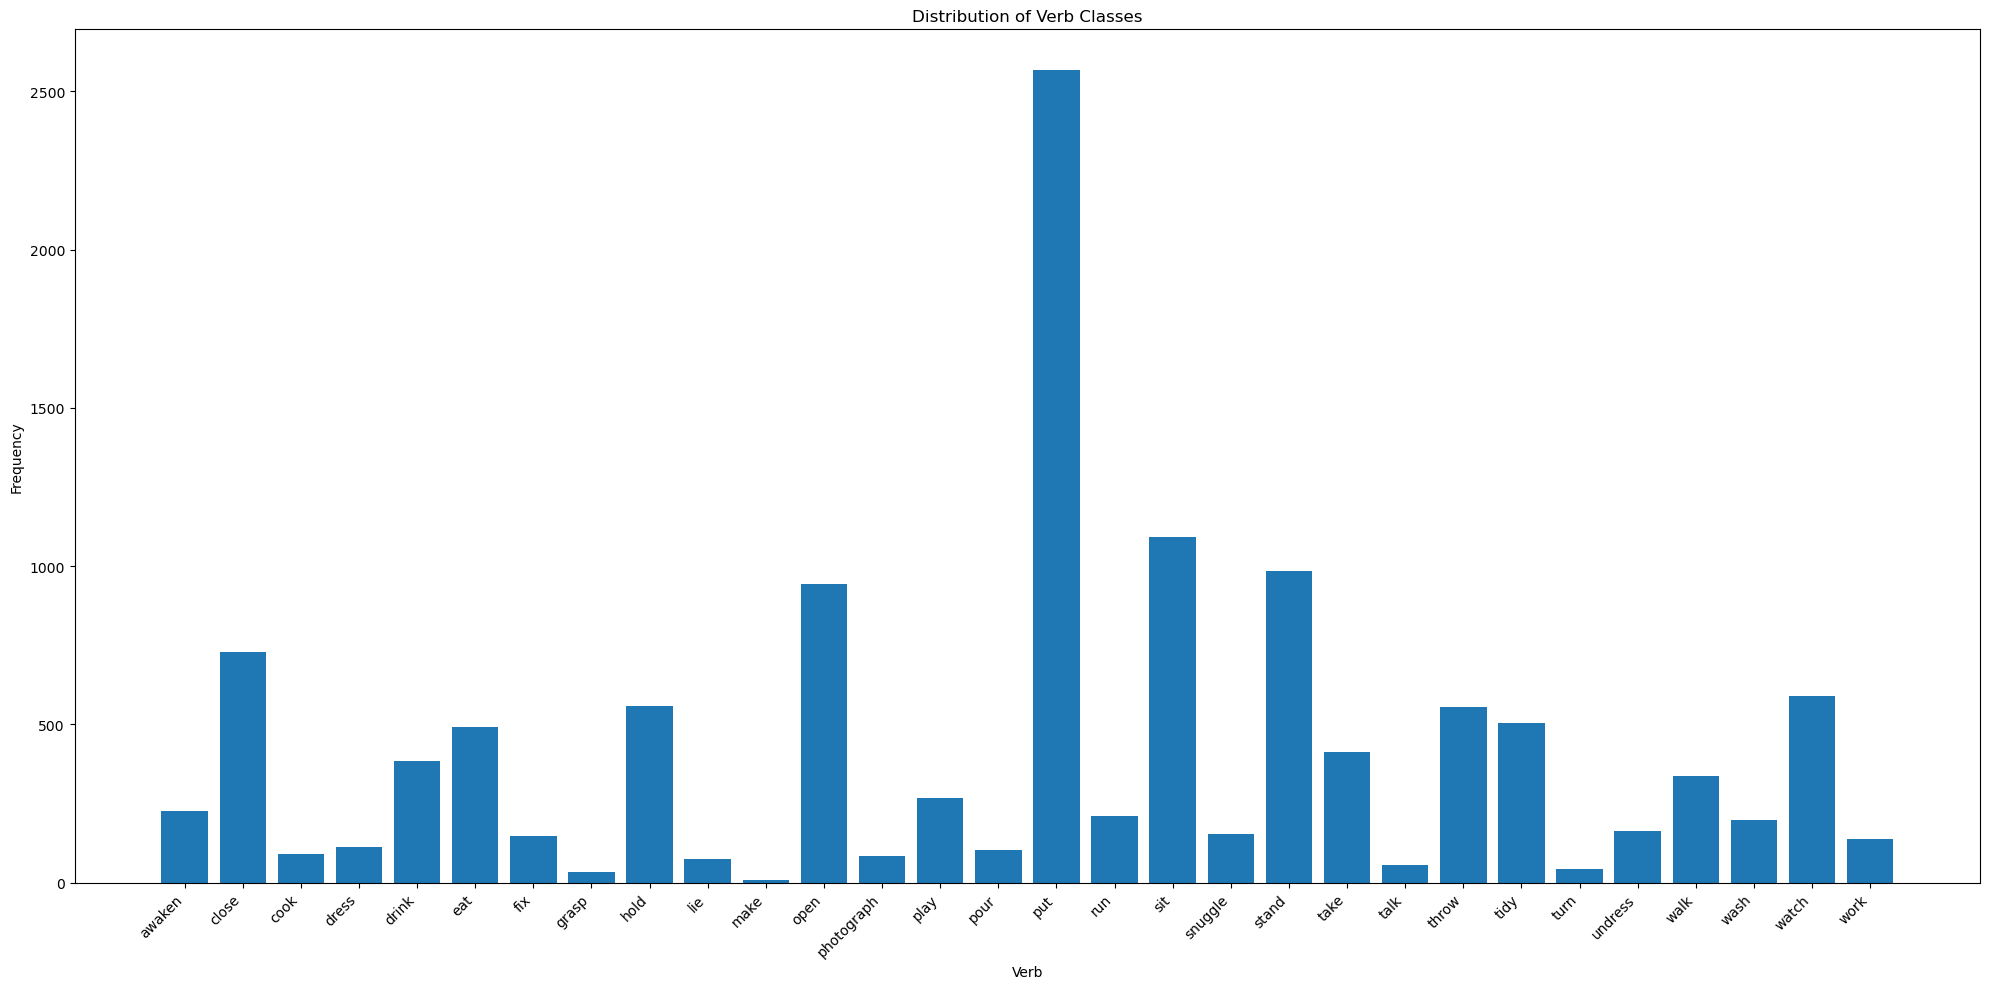

In [8]:
freqs = ag.verb_label_counts
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.bar(range(len(freqs)), freqs)
plt.xticks(range(len(freqs)), ag.verb_classes, rotation=45, ha='right')
plt.title('Distribution of Verb Classes')
plt.xlabel('Verb')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
